In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import warnings
from pandas.plotting import autocorrelation_plot

In [2]:
import skits

In [19]:
%pylab inline
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.9.0


# get data

In [3]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/data/Food_price_indices_data_jul.csv"
food_data = pd.read_csv(datafile)
food_data.head()

,Date,Food Price Index,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index
0,1/1990,108.7,112.3,94.3,106.4,73.0,201.5
1,2/1990,109.9,117.7,91.9,104.0,72.5,207.9
2,3/1990,107.9,119.6,73.6,102.1,74.6,218.0
3,4/1990,114.2,131.0,85.2,105.1,71.8,216.3
4,5/1990,111.2,130.5,70.0,105.3,74.4,207.2


In [4]:
#datafile2 = curr_directory + "/data/GLB.Ts+dSST.csv"
#temperature_data = pd.read_csv(datafile2)
#temperature_data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.29,-0.18,-0.11,-0.19,-0.11,-0.23,-0.20,-0.09,-0.15,-0.23,-0.2,-0.22,-0.18,***,***,-0.14,-0.17,-0.19
1,1881,-0.15,-0.17,0.04,0.04,0.02,-0.20,-0.06,-0.02,-0.13,-0.2,-0.21,-0.1,-0.09,-0.1,-0.18,0.04,-0.09,-0.18
2,1882,0.15,0.15,0.04,-0.18,-0.16,-0.25,-0.20,-0.05,-0.09,-0.24,-0.16,-0.24,-0.1,-0.09,0.07,-0.10,-0.17,-0.16
3,1883,-0.31,-0.38,-0.12,-0.17,-0.20,-0.12,-0.08,-0.15,-0.2,-0.14,-0.22,-0.15,-0.19,-0.19,-0.31,-0.16,-0.11,-0.19
4,1884,-0.15,-0.08,-0.37,-0.42,-0.36,-0.40,-0.34,-0.26,-0.27,-0.24,-0.29,-0.27,-0.29,-0.28,-0.13,-0.38,-0.33,-0.27


# clean the data

In [5]:
from Capstone.cleaning import cleaning

clean_temp_data = cleaning.clean_temperature_data_step1(temperature_data)
clean_temp_data = cleaning.clean_temperature_data_step2(clean_temp_data)

In [6]:
clean_temp_data.dtypes

Date           datetime64[ns]
Temperature           float64
dtype: object

In [7]:
clean_food_data = cleaning.clean_food_data(food_data)

In [8]:
#clean_food_data['Temperature'] = clean_temp_data['Temperature']

In [9]:
clean_food_data.tail()

,Date,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Temperature
337,2018-02-01,170.3,191.1,161.3,158.0,192.4,0.81
338,2018-03-01,171.0,197.4,165.4,156.8,185.5,0.91
339,2018-04-01,170.4,204.1,168.5,154.6,176.1,0.87
340,2018-05-01,169.3,215.2,172.6,150.6,175.3,0.82
341,2018-06-01,169.8,213.2,166.2,146.1,177.4,0.76


In [11]:
indexed_df = clean_food_data.set_index(['Date'])
indexed_df.to_csv('data/indexed_clean_df.csv')

# Data exploration and visualization
don't forget that the data is on a scale of 2002-2004 = 100.0

In [ ]:
indexed_df.describe()

In [ ]:
indexed_df.head()

In [ ]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = indexed_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [ ]:
pd.plotting.scatter_matrix(indexed_df, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [ ]:
# checking for collinearity
food_corr = np.corrcoef(indexed_df, rowvar=False)
eig_val, eig_vec = np.linalg.eig(food_corr)
eig_val

In [ ]:
indexed_df.plot()
plt.show()

In [ ]:
indexed_df.hist(figsize=(8,8))
plt.show()

# feature engineering

In [ ]:
df_diff = indexed_df.diff()

In [ ]:
df_diff.head()

In [ ]:
df_diff.plot()
plt.show()

In [ ]:
pd.plotting.scatter_matrix(df_diff, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [ ]:
from statsmodels.tsa.stattools import adfuller


def test_fuller(df):
    result = adfuller(df[1:])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

check differenced data for stationarity

In [ ]:
test_fuller(df_diff['Meat Price Index'])

In [ ]:
test_fuller(df_diff['Cereals Price Index'])

In [ ]:
test_fuller(df_diff['Dairy Price Index'])

In [ ]:
test_fuller(df_diff['Oils Price Index'])

In [ ]:
test_fuller(df_diff['Sugar Price Index'])

all adfuller tests show that the differenced data is stationary



In [13]:
# adjust data for tsfresh tool
tsfresh_data = pd.melt(clean_food_data, id_vars='Date')

In [13]:
tsfresh_data.head()

,Date,variable,value
0,1990-01-01,Meat Price Index,112.3
1,1990-02-01,Meat Price Index,117.7
2,1990-03-01,Meat Price Index,119.6
3,1990-04-01,Meat Price Index,131.0
4,1990-05-01,Meat Price Index,130.5


# Unsupervised learning

In [44]:
# dtw
from dtw import dtw

In [14]:
from tsfresh import extract_features
extracted_features = extract_features(tsfresh_data, column_id='variable', column_sort='Date')

Feature Extraction: 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


In [15]:
extracted_features.shape

(6, 794)

In [ ]:
extracted_features.head()

In [13]:
from skits.preprocessing import (ReversibleImputer, 
                                 DifferenceTransformer)
from skits.feature_extraction import (AutoregressiveTransformer,
                                      SeasonalTransformer)
from skits.pipeline import ForecasterPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

In [14]:
meat_y = clean_food_data['Meat Price Index'].copy()
meat_X = meat_y.copy()[:, np.newaxis]


In [18]:
pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=1)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_yr_differencer', DifferenceTransformer(period=12)),
    ('pre_yr_diff_imputer', ReversibleImputer()),
    ('pre_scaler', StandardScaler()),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=1)),
        ('seasonal_features', SeasonalTransformer(seasonal_period=12)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('post_feature_scaler', StandardScaler()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline = pipeline.fit(meat_X, meat_y)

In [15]:
# each step alone
diff_1 = DifferenceTransformer(period=1)
rev_imp = ReversibleImputer()
diff_12 = DifferenceTransformer(period=12)
scaler = StandardScaler()
auto_trans = AutoregressiveTransformer(num_lags=1)
seasonal_trans = SeasonalTransformer(seasonal_period=12)
regr = LinearRegression(fit_intercept=False)

In [16]:
diffed = diff_1.fit_transform(meat_X, meat_y)

In [17]:
reved = rev_imp.fit(X=diffed)

In [18]:
transformed_rev = rev_imp.transform(diffed)

In [19]:
diffed_12 = diff_12.fit_transform(transformed_rev, meat_y)

In [28]:
reved_diffed_12 = rev_imp.fit(diffed_12).transform(diffed_12)


In [21]:
scaled = scaler.fit_transform(reved_diffed_12, meat_y)

In [22]:
combine_features = FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=1)),
        ('seasonal_features', SeasonalTransformer(seasonal_period=12)),
    ])

X_features = combine_features.fit(scaled, meat_y).transform(scaled)
print("Combined space has", X_features.shape[1], "features")


Combined space has 2 features


In [23]:
reved_features = rev_imp.fit(X_features).transform(X_features)
#reved_features = rev_imp.transform(X_features)

In [24]:
rescaled = scaler.fit_transform(reved_features)

In [29]:
regr.fit(rescaled, meat_y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [30]:
regr.score(rescaled, meat_y)

-19.884147710065

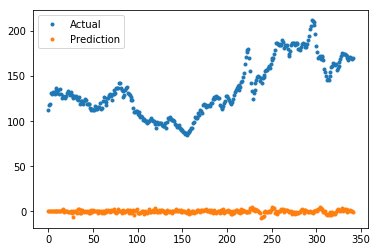

In [34]:
plt.plot(meat_y, '.')
plt.plot(regr.predict(rescaled), '.')
plt.legend(['Actual', 'Prediction'])

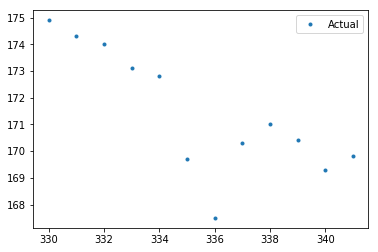

In [32]:
plt.plot(meat_y[-12:], '.');
#plt.plot(pipeline.predict(meat_X[-10:], to_scale=True), '.')
plt.legend(['Actual', 'Prediction']);


In [ ]:
from tsfresh import extract_relevant_features
extracted_features = extract_relevant_features(tsfresh_data2, tsfresh_data2, column_id='variable')


In [13]:
# training set up to 2016
train = indexed_df.loc['1990':'2016']
test = indexed_df.loc['2017':'2018']

In [39]:
test.tail()

,Meat Price Index,Dairy Price Index,Cereals Price Index,Oils Price Index,Sugar Price Index,Temperature
Date,,,,,,
2018-02-01,170.3,191.1,161.3,158.0,192.4,0.81
2018-03-01,171.0,197.4,165.4,156.8,185.5,0.91
2018-04-01,170.4,204.1,168.5,154.6,176.1,0.87
2018-05-01,169.3,215.2,172.6,150.6,175.3,0.82
2018-06-01,169.8,213.2,166.2,146.1,177.4,0.76


In [26]:
# trying pca woo
test_pca = PCA(n_components=3)
test_pca.fit(extracted_features)
test_pca.transform(extracted_features)

array([[-1.04221151e+05, -4.62528596e+05, -6.83804901e+03],
       [ 8.74211990e+05, -3.59700070e+05,  6.66161243e+04],
       [-1.66215922e+06, -8.38462307e+05, -3.31131400e+04],
       [-2.87006236e+05, -4.11288812e+05, -1.33943017e+04],
       [ 1.09092426e+07,  9.16457584e+05, -1.19653711e+04],
       [-9.73006800e+06,  1.15552220e+06, -1.30526249e+03]])

In [47]:
dist, cost, acc, path = dtw.accelerated_dtw(indexed_df['Meat Price Index'].values,
                indexed_df['Dairy Price Index'].values, dist='euclidean' )

Populating the interactive namespace from numpy and matplotlib


(-0.5, 341.5)

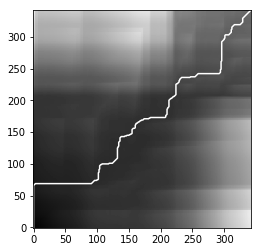

In [53]:
imshow(acc.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot(path[0], path[1], 'w')
xlim((-0.5, acc.shape[0]-0.5))
ylim((-0.5, acc.shape[1]-0.5))

In [64]:
def plot_dtw(x, y, dist, cmap):
    dist, cost, acc, path = dtw.accelerated_dtw(x, y , dist=dist)
    imshow(acc.T, origin='lower', cmap=cmap, interpolation='nearest')
    plot(path[0], path[1], 'w')
    xlim((-0.5, acc.shape[0]-0.5))
    ylim((-0.5, acc.shape[1]-0.5))

<Figure size 432x288 with 0 Axes>

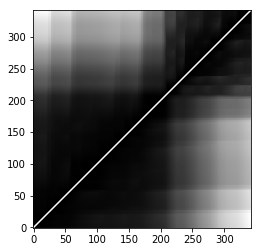

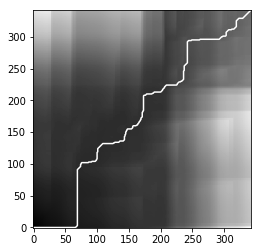

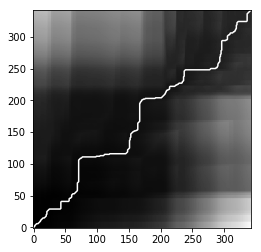

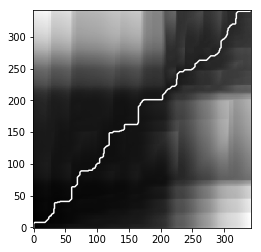

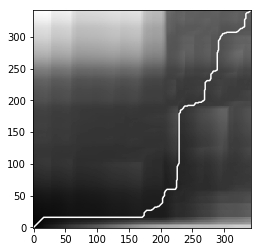

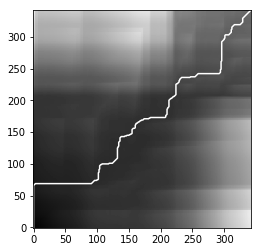

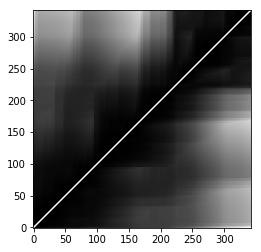

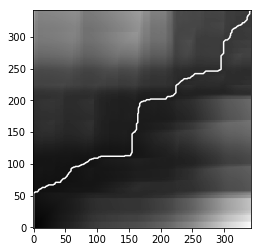

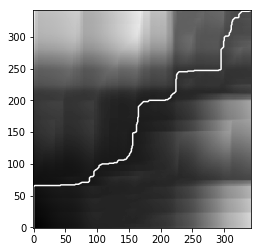

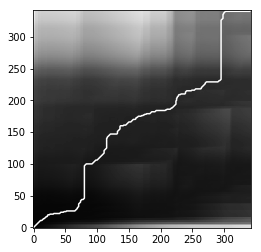

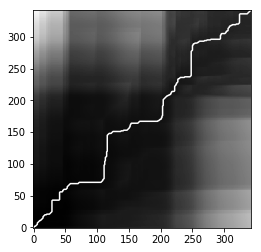

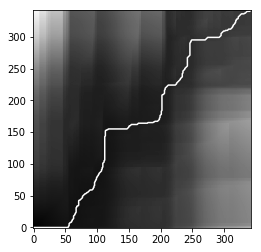

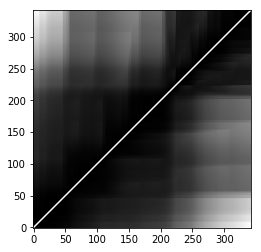

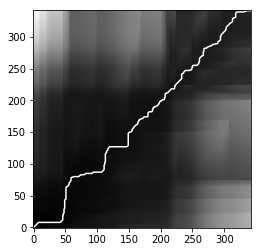

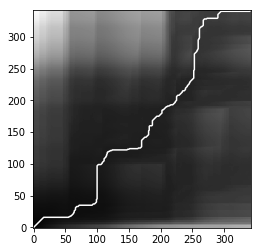

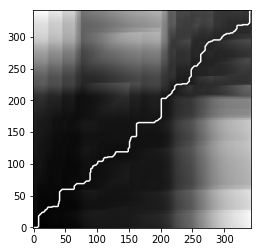

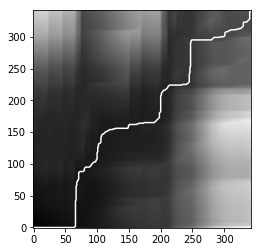

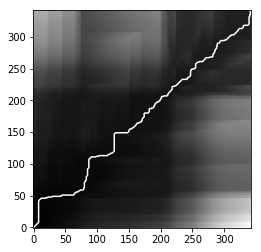

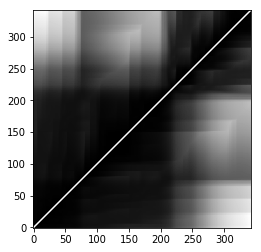

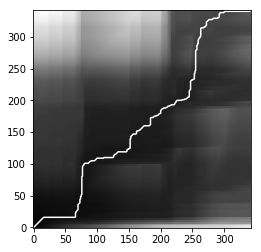

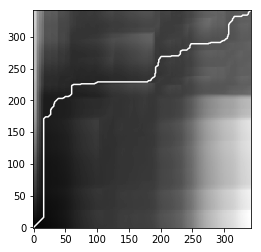

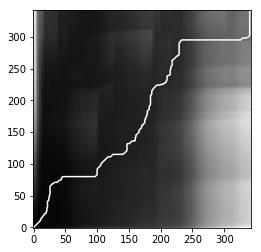

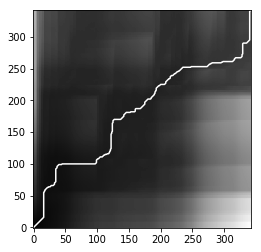

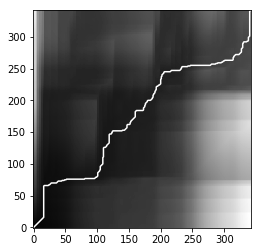

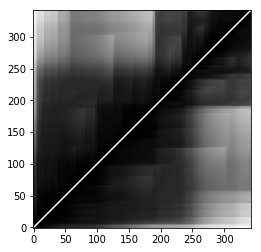

In [78]:
indices = [indexed_df['Dairy Price Index'].values,
           indexed_df['Meat Price Index'].values,
           indexed_df['Oils Price Index'].values,
           indexed_df['Cereals Price Index'].values,
           indexed_df['Sugar Price Index'].values]

plt.figure()
for i in indices:
    for j in indices:
        plt.figure()
        
        plot_dtw(i, j, 'euclidean', cm.gray)
plt.show()

# Supervised Learning

In [15]:
from Capstone.models import modeling

In [14]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [15]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [18]:
params = {'lags': 2, 'diffs': 1, 'ma': 12}

In [13]:
pfarima_model = pf.ARIMA(data=train, target='Sugar Price Index', ar=2, ma=12, integ=1, family=pf.Normal())
#pfvar_model = pf.VAR(data=train, lags=2, integ=1)

In [14]:
pfarima_model.fit("M-H")

Acceptance rate of Metropolis-Hastings is 0.07275
Acceptance rate of Metropolis-Hastings is 0.41935
Acceptance rate of Metropolis-Hastings is 0.2919

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.292025


In [15]:
arima_yhat = pfarima_model.predict(h=12)
#var_yhat = pfvar_model.predict(h=3)

In [16]:
arima_yhat

,Differenced Sugar Price Index
Date,
2016-12-26,-17.634198
2017-01-26,-4.749363
2017-02-24,2.952545
2017-03-27,-3.322794
2017-04-26,3.420281
2017-05-27,8.708049
2017-06-26,4.755249
2017-07-27,2.968983
2017-08-27,4.872185


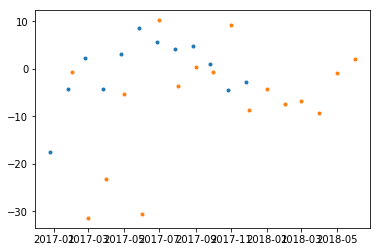

In [37]:
plt.plot(arima_yhat)
plt.plot(diff_test['Sugar Price Index'], '.')

In [16]:
p_values = [0, 1, 4, 6, 8, 10, 12]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

In [15]:
evaluate_models(indexed_df['Meat Price Index'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=2164.167
ARIMA(0, 0, 1) MSE=619.085
ARIMA(0, 1, 0) MSE=19.771
ARIMA(0, 1, 1) MSE=17.933
ARIMA(0, 1, 2) MSE=16.319
ARIMA(0, 2, 0) MSE=18.010
ARIMA(0, 2, 1) MSE=21.501
ARIMA(1, 0, 0) MSE=19.715
ARIMA(1, 1, 0) MSE=17.204
ARIMA(1, 2, 0) MSE=17.513
ARIMA(1, 2, 1) MSE=18.573
ARIMA(1, 2, 2) MSE=18.845
ARIMA(2, 0, 0) MSE=17.094
ARIMA(2, 1, 0) MSE=16.380
ARIMA(2, 1, 1) MSE=16.935
ARIMA(2, 2, 0) MSE=19.910
ARIMA(2, 2, 1) MSE=17.311
ARIMA(4, 0, 0) MSE=16.679
ARIMA(4, 1, 0) MSE=16.054
ARIMA(4, 1, 1) MSE=16.366
ARIMA(4, 2, 0) MSE=21.529
ARIMA(4, 2, 1) MSE=16.516
ARIMA(6, 0, 0) MSE=15.763
ARIMA(6, 1, 0) MSE=15.952
ARIMA(6, 1, 1) MSE=15.922
ARIMA(6, 2, 0) MSE=21.485
ARIMA(6, 2, 1) MSE=16.397
ARIMA(8, 1, 0) MSE=15.737
ARIMA(8, 1, 1) MSE=15.882
ARIMA(8, 2, 0) MSE=19.093
ARIMA(8, 2, 1) MSE=16.700
ARIMA(10, 1, 0) MSE=15.717
ARIMA(10, 1, 1) MSE=16.129
ARIMA(10, 2, 0) MSE=17.801
ARIMA(12, 0, 0) MSE=15.883
ARIMA(12, 1, 0) MSE=16.347
ARIMA(12, 1, 1) MSE=16.039
ARIMA(12, 2, 0) MSE=17.732
Be

In [17]:
evaluate_models(indexed_df['Sugar Price Index'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=13351.405
ARIMA(0, 0, 1) MSE=3825.773
ARIMA(0, 1, 0) MSE=442.289
ARIMA(0, 1, 1) MSE=383.679
ARIMA(0, 1, 2) MSE=387.320
ARIMA(0, 2, 0) MSE=578.035
ARIMA(0, 2, 1) MSE=479.820
ARIMA(0, 2, 2) MSE=389.157
ARIMA(1, 0, 0) MSE=445.895
ARIMA(1, 0, 2) MSE=391.136
ARIMA(1, 1, 0) MSE=393.240
ARIMA(1, 1, 1) MSE=387.880
ARIMA(1, 2, 0) MSE=570.825
ARIMA(1, 2, 2) MSE=392.965
ARIMA(4, 0, 0) MSE=402.168
ARIMA(4, 1, 0) MSE=397.253
ARIMA(4, 2, 0) MSE=477.886
ARIMA(6, 0, 0) MSE=410.140
ARIMA(6, 0, 1) MSE=410.708
ARIMA(6, 1, 0) MSE=407.524
ARIMA(6, 2, 0) MSE=494.536
ARIMA(8, 0, 0) MSE=425.768
ARIMA(8, 1, 0) MSE=420.714
ARIMA(8, 2, 0) MSE=495.485
ARIMA(10, 0, 0) MSE=430.878
ARIMA(10, 1, 0) MSE=427.126
ARIMA(10, 2, 0) MSE=481.801
ARIMA(10, 2, 1) MSE=431.666
ARIMA(12, 0, 0) MSE=435.997
ARIMA(12, 1, 0) MSE=425.639
ARIMA(12, 2, 0) MSE=459.959
Best ARIMA(0, 1, 1) MSE=383.679


In [30]:
evaluate_models(indexed_df['Oils Price Index'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=5070.353
ARIMA(0, 0, 1) MSE=1435.087
ARIMA(0, 1, 0) MSE=96.254
ARIMA(0, 1, 1) MSE=86.371
ARIMA(0, 1, 2) MSE=85.462
ARIMA(0, 2, 0) MSE=117.579
ARIMA(0, 2, 1) MSE=99.086
ARIMA(0, 2, 2) MSE=96.773
ARIMA(1, 0, 0) MSE=95.426
ARIMA(1, 0, 1) MSE=85.991
ARIMA(1, 0, 2) MSE=85.106
ARIMA(1, 1, 0) MSE=81.964
ARIMA(1, 1, 1) MSE=86.965
ARIMA(1, 2, 0) MSE=107.255
ARIMA(1, 2, 2) MSE=95.309
ARIMA(4, 0, 0) MSE=93.793
ARIMA(4, 1, 0) MSE=94.875
ARIMA(4, 1, 1) MSE=95.340
ARIMA(4, 1, 2) MSE=98.165
ARIMA(4, 2, 0) MSE=113.175
ARIMA(4, 2, 1) MSE=113.484
ARIMA(6, 1, 0) MSE=95.057
ARIMA(6, 1, 1) MSE=91.468
ARIMA(6, 2, 0) MSE=117.917
ARIMA(6, 2, 1) MSE=106.538
ARIMA(6, 2, 2) MSE=102.384
ARIMA(8, 1, 0) MSE=98.529
ARIMA(8, 2, 0) MSE=119.353
ARIMA(8, 2, 1) MSE=107.571
ARIMA(8, 2, 2) MSE=117.907
ARIMA(10, 2, 0) MSE=110.326
ARIMA(12, 1, 0) MSE=101.953
ARIMA(12, 2, 0) MSE=115.709
Best ARIMA(1, 1, 0) MSE=81.964


In [31]:
evaluate_models(indexed_df['Cereals Price Index'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=5072.801
ARIMA(0, 0, 1) MSE=1433.610
ARIMA(0, 1, 0) MSE=67.443
ARIMA(0, 1, 1) MSE=61.953
ARIMA(0, 1, 2) MSE=59.856
ARIMA(0, 2, 0) MSE=87.678
ARIMA(0, 2, 1) MSE=68.793
ARIMA(0, 2, 2) MSE=73.606
ARIMA(1, 0, 0) MSE=66.647
ARIMA(1, 0, 2) MSE=59.553
ARIMA(1, 1, 0) MSE=60.060
ARIMA(1, 1, 1) MSE=60.012
ARIMA(1, 1, 2) MSE=60.287
ARIMA(1, 2, 0) MSE=75.742
ARIMA(1, 2, 1) MSE=61.989
ARIMA(1, 2, 2) MSE=62.125
ARIMA(4, 0, 0) MSE=61.408
ARIMA(4, 0, 1) MSE=64.270
ARIMA(4, 1, 0) MSE=61.453
ARIMA(4, 1, 1) MSE=62.688
ARIMA(4, 2, 0) MSE=72.554
ARIMA(4, 2, 1) MSE=63.173
ARIMA(4, 2, 2) MSE=65.324
ARIMA(6, 0, 0) MSE=64.117
ARIMA(6, 0, 1) MSE=64.578
ARIMA(6, 1, 0) MSE=63.510
ARIMA(6, 1, 1) MSE=64.959
ARIMA(6, 2, 0) MSE=73.022
ARIMA(6, 2, 2) MSE=66.779
ARIMA(8, 0, 0) MSE=65.434
ARIMA(8, 0, 1) MSE=65.302
ARIMA(8, 1, 0) MSE=65.683
ARIMA(8, 1, 1) MSE=66.309
ARIMA(8, 2, 0) MSE=76.038
ARIMA(8, 2, 2) MSE=67.955
ARIMA(10, 0, 0) MSE=67.264
ARIMA(10, 0, 1) MSE=67.312
ARIMA(10, 1, 0) MSE=67.821
ARIMA

In [32]:
evaluate_models(indexed_df['Dairy Price Index'].values, p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=5998.958
ARIMA(0, 0, 1) MSE=1593.119
ARIMA(0, 1, 0) MSE=111.099
ARIMA(0, 1, 1) MSE=81.258
ARIMA(0, 1, 2) MSE=83.924
ARIMA(0, 2, 0) MSE=104.083
ARIMA(0, 2, 1) MSE=103.773
ARIMA(0, 2, 2) MSE=99.044
ARIMA(1, 0, 0) MSE=110.859
ARIMA(1, 0, 1) MSE=80.841
ARIMA(1, 0, 2) MSE=83.669
ARIMA(1, 1, 0) MSE=81.284
ARIMA(1, 1, 1) MSE=84.335
ARIMA(1, 1, 2) MSE=89.716
ARIMA(1, 2, 0) MSE=112.569
ARIMA(4, 1, 0) MSE=90.384
ARIMA(4, 2, 0) MSE=104.493
ARIMA(4, 2, 1) MSE=98.007
ARIMA(6, 1, 0) MSE=92.379
ARIMA(6, 1, 1) MSE=90.937
ARIMA(6, 2, 0) MSE=104.344
ARIMA(6, 2, 1) MSE=99.228
ARIMA(8, 1, 0) MSE=94.102
ARIMA(8, 2, 0) MSE=104.945
ARIMA(8, 2, 1) MSE=106.861
ARIMA(10, 1, 0) MSE=97.620
ARIMA(10, 2, 0) MSE=107.733
ARIMA(10, 2, 1) MSE=107.009
ARIMA(10, 2, 2) MSE=109.358
ARIMA(12, 2, 0) MSE=109.344
ARIMA(12, 2, 1) MSE=100.619
Best ARIMA(1, 0, 1) MSE=80.841


# Save Model

In [33]:
sugar_model = ARIMA(indexed_df['Sugar Price Index'].values, order=(0,1,1))
sugar_model_fit = sugar_model.fit()
sugar_model_fit.save('SugarARIMA.pkl')

# Forecasting

In [34]:
meat_model = ARIMA(indexed_df['Meat Price Index'].values, order=(10,1,0))
meat_model_fit = meat_model.fit()
meat_model_fit.save('MeatARIMA.pkl')

In [36]:
oils_model = ARIMA(indexed_df['Oils Price Index'].values, order=(1,1,0))
oils_model_fit = oils_model.fit()
oils_model_fit.save('OilsARIMA.pkl')

In [37]:
cereal_model = ARIMA(indexed_df['Cereals Price Index'].values, order=(0,1,1))
cereal_model_fit = cereal_model.fit()
cereal_model_fit.save('CerealsARIMA.pkl')

In [35]:
dairy_model = ARIMA(indexed_df['Dairy Price Index'].values, order=(0,1,1))
dairy_model_fit = dairy_model.fit()
dairy_model_fit.save('DairyARIMA.pkl')

In [29]:
loaded.fittedvalues

array([-6.65046889e-02,  2.08954801e+00,  2.93837498e+00, -1.83410178e+00,
       -2.84170574e+00, -7.84490842e+00, -2.38011825e+00, -4.88851859e+00,
        2.56557756e+00, -7.84813182e+00,  4.30779282e+00, -3.50835585e+00,
       -3.80786314e+00, -1.78129324e-01,  3.40222185e+00, -4.76714750e+00,
       -3.28867285e+00,  9.97831995e+00,  2.11973244e+00, -5.49982267e+00,
        1.11792844e+00, -1.41069481e+00, -2.01111325e+00,  2.53600167e+00,
       -4.70363526e+00, -8.67519496e-01,  2.29008638e+00,  5.78336831e+00,
       -1.55032831e+00,  4.69072917e+00, -2.12628646e+00, -1.85231690e+00,
       -2.18625810e+00, -2.47896691e+00,  1.16507161e-01, -2.36539439e+00,
        1.29582203e+00,  1.19601200e+00,  1.06337368e+01, -1.26389632e+00,
        4.12276787e+00, -9.47479193e+00, -2.67185149e-01, -1.83668963e+00,
        1.74337050e+00,  3.31758742e+00, -2.25117804e+00,  2.97161707e+00,
       -2.38645173e+00,  3.63466005e+00,  3.55017389e+00, -5.39682513e+00,
        5.09059253e+00,  

In [45]:
print(help(dtw))

Help on module dtw.dtw in dtw:

NAME
    dtw.dtw

FUNCTIONS
    accelerated_dtw(x, y, dist, warp=1)
        Computes Dynamic Time Warping (DTW) of two sequences in a faster way.
        Instead of iterating through each element and calculating each distance,
        this uses the cdist function from scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)
        
        :param array x: N1*M array
        :param array y: N2*M array
        :param string or func dist: distance parameter for cdist. When string is given, cdist uses optimized functions for the distance metrics.
        If a string is passed, the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
        :param int warp: how man

In [18]:
pipeline.predict(meat_X[-10:])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [33]:
diff_test = test.diff()

diff_test['Sugar Price Index']

Date
2017-01-01     NaN
2017-02-01    -0.6
2017-03-01   -31.4
2017-04-01   -23.2
2017-05-01    -5.4
2017-06-01   -30.6
2017-07-01    10.2
2017-08-01    -3.6
2017-09-01     0.3
2017-10-01    -0.7
2017-11-01     9.2
2017-12-01    -8.6
2018-01-01    -4.2
2018-02-01    -7.5
2018-03-01    -6.9
2018-04-01    -9.4
2018-05-01    -0.8
2018-06-01     2.1
Name: Sugar Price Index, dtype: float64

In [24]:
from statsmodels.tsa.arima_model import ARIMAResults
loaded = ARIMAResults.load('SavedARIMA.pkl')

In [22]:
model_fit.save('SavedARIMA.pkl')

In [21]:
model_fit = model.fit()